<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/13.ResNet/ResNet18_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Convergence using ResNet18
In this notebook, will modify the code in the link [CIFAR-10 - 92% Acc within 10 Epochs](https://mc.ai/tutorial-1-cifar10-with-google-colabs-free-gpu%E2%80%8A-%E2%80%8A92-5/) as below and target 90% accuracy or more

*   Use ResNet18 model instead
*   Model must look like Conv->B1->B2->B3->B4 and not individually called Convs.
*   Batch Size 128
*   Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
*   Random Crop of 32 with padding of 4px
*   Horizontal Flip (0.5)
*   Optimizer: SGD, Weight-Decay: 5e-4
*   NOT-OneCycleLR
*   Train for 300 Epochs




In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import datetime as dt

## Eager Execution
Uses Eager execution runtime. More details on Eager Execution:

https://github.com/gkdivya/EVA/blob/master/12.SuperConvergence/EagerExecution.md




In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE = 128 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 300 #@param {type:"integer"}

## Initializing weights

**Initialization of Convolution layer**

For initializing weights in Convolution layer, Keras uses `Xavier Glorot init` weight initialization algorithm and PyTorch uses a different version of `Kaiming He init`. Since we are trying to replicate DavidNet's PyTorch version code in Keras, we are initializing the weights same as what is been implemented in PyTorch.

PyTorch takes the inverse square root of the layer’s fan-in as a bound, and then generates a random initial weight in the range [-bound, bound]

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 13s 0us/step


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64).shuffle(10000)
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
train_dataset = train_dataset.map(lambda x, y: (tf.image.central_crop(x, 0.75), y))
train_dataset = train_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
train_dataset = train_dataset.repeat()

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(5000).shuffle(10000)
valid_dataset = valid_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
valid_dataset = valid_dataset.map(lambda x, y: (tf.image.central_crop(x, 0.75), y))
valid_dataset = valid_dataset.repeat()

In [0]:
def res_net_block(input_data, filters, conv_size):
  x = tf.keras.layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, input_data])
  x = tf.keras.layers.Activation('relu')(x)
  return x

In [0]:
callbacks = [
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")), write_images=True),
]

In [0]:
inputs = tf.keras.Input(shape=(24, 24, 3))
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(3)(x)

num_res_net_blocks = 3
for i in range(num_res_net_blocks):
  x = res_net_block(x, 64, 3)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

res_net_model = tf.keras.Model(inputs, outputs)

In [22]:
res_net_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
res_net_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 20, 20, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 6, 6, 64)     0           conv2d_3[0][0]                   
______________________________________________________________________________________________

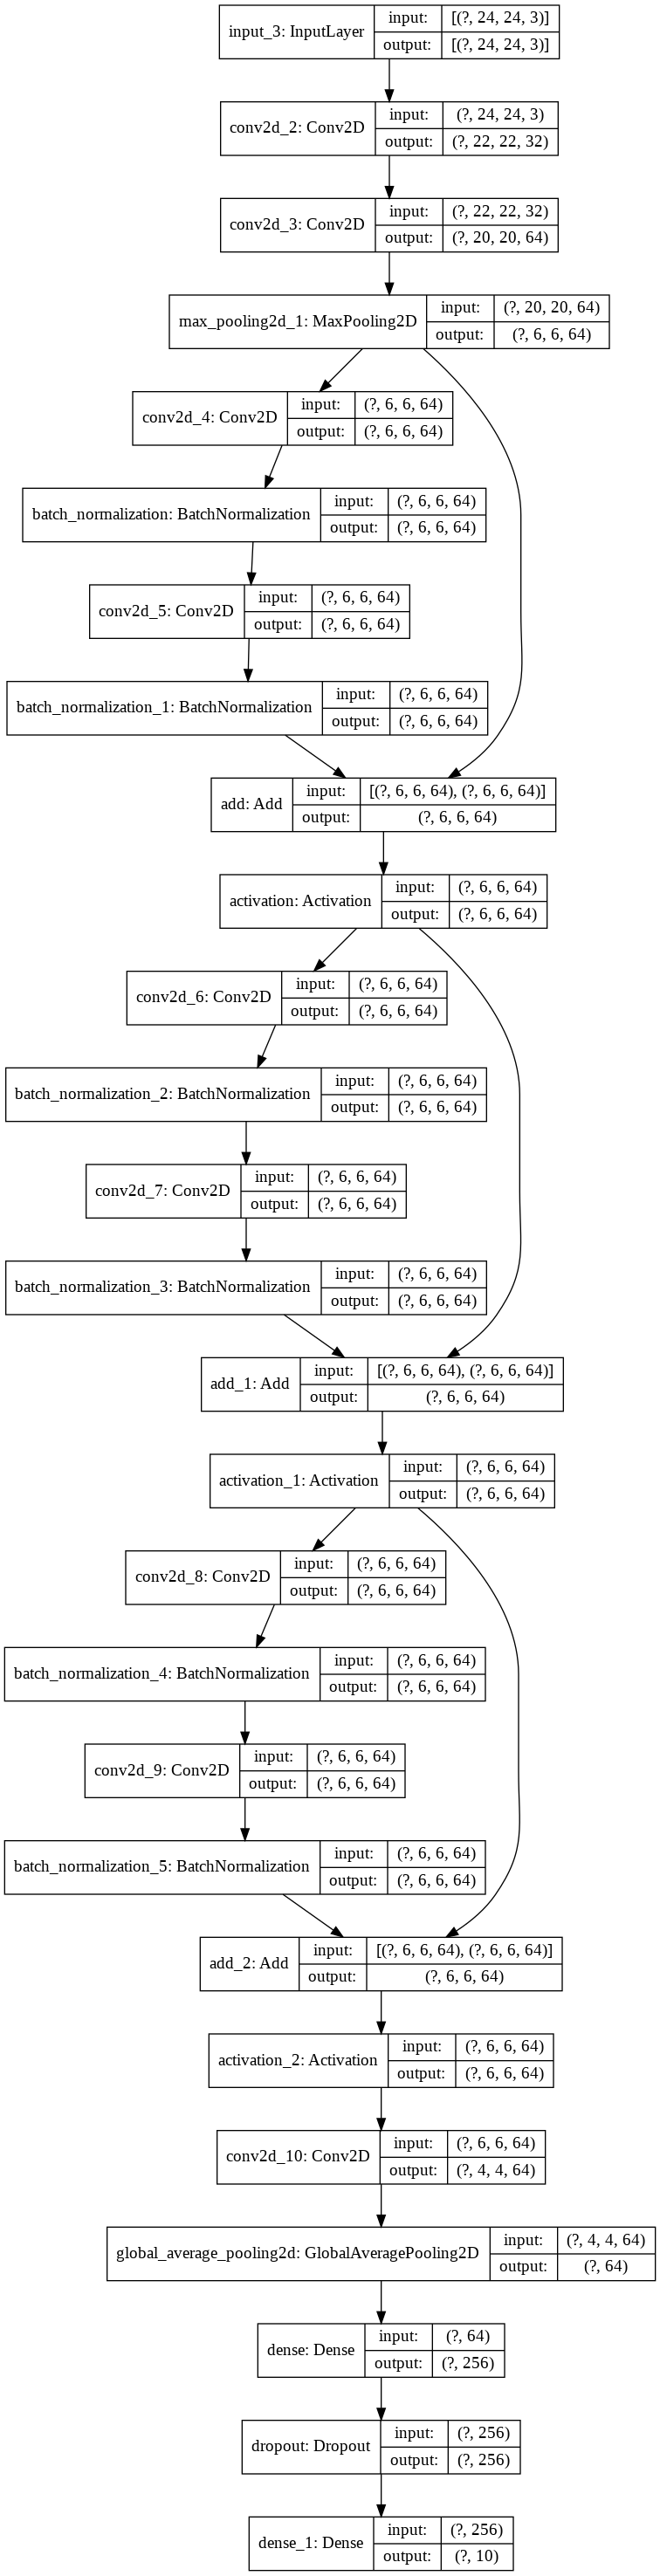

In [26]:
tf.keras.utils.plot_model(res_net_model, show_shapes=True  ,to_file='model.png')

In [0]:
res_net_model.fit(train_dataset, epochs=30, steps_per_epoch=195,
          validation_data=valid_dataset,
          validation_steps=3, callbacks=callbacks)